In [1]:
using Revise
using Plots, LinearAlgebra

In [2]:
using ForwardDiff

In [10]:
function f(x)
    return x[1]^2 + x[2]^2
end

f (generic function with 1 method)

In [13]:
function g(y)
    ForwardDiff.gradient(f, y)
end

g (generic function with 1 method)

In [14]:
g([1.0, 2.0])

2-element Vector{Float64}:
 2.0
 4.0

In [15]:
function h(z)
    ForwardDiff.jacobian(g, z)
end

h (generic function with 1 method)

In [16]:
h([1.0, 2.0])

2×2 Matrix{Float64}:
 2.0  0.0
 0.0  2.0

In [16]:
aa = randn(2,2)
bb = randn(2,2)

2×2 Matrix{Float64}:
  0.318626  -0.789885
 -0.574313   0.564495

### Define the system dynamics and observation models

In [2]:
# calculate LQR cost:
η = 1 # Efficiency
Q_nom = 2.2 # Nominal capacity
dt = 1.0 # Discretization time
A = [1.0 0.0; 0.0 1.0]
B = dt * η / Q_nom * [1.0 0; 0 1.0]

function state_dynamics(SOC, I)
    SOC = A * SOC .+ B * I
    #SOC = clamp.(SOC, 0.0, 1.0)
    return SOC
end

function measurement_dynamics(SOC)
    # LTO
    OCV_LTO = 2.5 + 0.3 * SOC[1] + 0.1 * tanh(8 * (SOC[1] - 0.5)) + 0.05 * sin(5 * π * SOC[1])   
    # LCO
    OCV_LCO = 3.7 + 0.5 * SOC[2] + 0.3 * sin(2 * π * SOC[2])
    return [OCV_LTO; OCV_LCO]
end
"""
function measurement_dynamics_jacobian(SOC)
    d_OCV_LTO = [0.3 + 0.8 * sech(8 * (SOC[1] - 0.5))^2 + 0.25 * π * cos(5 * π * SOC[1]); 0.0]
    d_OCV_LCO = [0.0; 0.5 + 0.6 * π * cos(2 * π * SOC[2])]
    return hcat(d_OCV_LTO, d_OCV_LCO)
end
"""
W = 0.1 * [1.0 0.0; 0.0 1.0]
V = 0.1 * [1.0 0.0; 0.0 1.0];

In [3]:
include("./src/eKF.jl")

update_predict (generic function with 1 method)

### Visualize the observation models

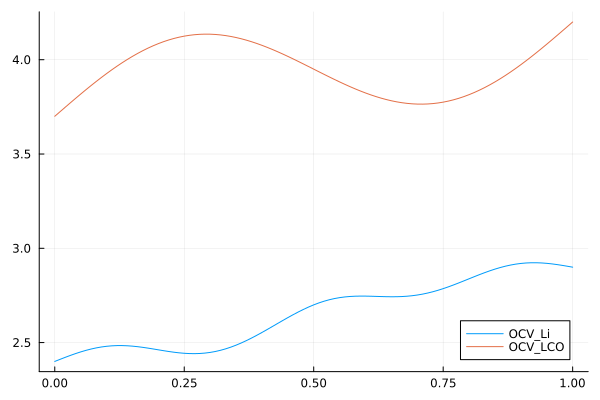

In [4]:
Ys = measurement_dynamics.([[i;i] for i in 0:0.01:1])
Ys = reduce(hcat, Ys)
plot(0:0.01:1, Ys[1,:], label="OCV_Li")
plot!(0:0.01:1, Ys[2,:], label="OCV_LCO")

### Define the extended Kalman Filter

In [5]:
eKF = ExtendedKalmanFilter(state_dynamics, measurement_dynamics, W, V)

ExtendedKalmanFilter(Main.state_dynamics, Main.measurement_dynamics, [0.1 0.0; 0.0 0.1], [0.1 0.0; 0.0 0.1])

### Initialize the control sampling object

In [6]:
N = 8 # prediction horizon length
Q = 1.0
R = 0.1
set_point = 0.7
running_cost = (x, u) -> Q * (sum(x) - set_point)^2  + u' * R * u
running_cost_stochastic = (x, cov, u) -> Q * (sum(x) - set_point)^2 + Q * tr(cov) + u' * R * u

#20 (generic function with 1 method)

### Initialize the model predictive control solver and the simulation loop

In [7]:
include("./src/MPCs.jl")
include("./simulate.jl")

simulate_mpc (generic function with 1 method)

In [8]:
function constraint_function(x, u)
    u_max = 5.0
    return [-x; x .- 1; u .- u_max; -u .- u_max]
end

constraint_function (generic function with 1 method)

In [9]:
# Define the linear problem
linear_problem = MPC_Prob(
    state_dynamics,
    2, # state dimension
    2, # control dimension
    N, # prediction horizon
    running_cost,
    constraint_function
)

# information state typically refers to the density or anything that represents the state
# and its uncertainty
function information_state_dynamics(x₀₀, Σ₀₀, u₀)
    x₁₁, Σ₁₁ = update_predict(x₀₀, Σ₀₀, u₀, eKF)
    #x₁₁, Σ₁₁ = x₀₀, Σ₀₀
    return x₁₁, Σ₁₁
end

nonlinear_problem = MPC_Prob(
    information_state_dynamics,
    2, # state dimension
    2, # control dimension
    N, # prediction horizon
    running_cost_stochastic,
    constraint_function
)

MPC_Prob(Main.information_state_dynamics, 2, 2, 8, var"#20#21"(), Main.constraint_function)

In [10]:
x₀₀ = [0.2; 0.2]
Σ₀₀ = 0.1 * Matrix{Float64}(I, 2, 2)
L = 10
num_simulations = 2
cost_rec = zeros(num_simulations)
est_err_rec = zeros(num_simulations)
T = 50
function simulation_run()
    X_rec, U_rec, _, X_true_rec = simulate_nonlinear_MPC(nonlinear_problem, linear_problem,
                                                        x₀₀, Σ₀₀, T, L; u_noise_cov = 0.01)
    achieved_cost = sum([running_cost(X_true_rec[k], U_rec[k]) for k in 1:T]) / T
    achieved_est_err = sum([norm(X_rec[k] - X_true_rec[k]) for k in 1:T]) / T
    return achieved_cost, achieved_est_err
end
for i in 1:num_simulations
    println("Simulation: ", i)
    if i==num_simulations
        @time begin
        achieved_cost, achieved_est_err = simulation_run()
        end
    else
        achieved_cost, achieved_est_err = simulation_run()
    end
    cost_rec[i] = achieved_cost
    est_err_rec[i] = achieved_est_err
end
println("Average Achieved Cost: ", sum(cost_rec) / num_simulations)
println("Average Achieved Estimation Error: ", sum(est_err_rec) / num_simulations)

Simulation: 1

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



MethodError: MethodError: Cannot `convert` an object of type AffExpr to an object of type VariableRef
The function `convert` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  (::Type{GenericVariableRef{T}} where T)(::Any, !Matched::Any)
   @ JuMP ~/.julia/packages/JuMP/RGIK3/src/variables.jl:256
  convert(::Type{T}, !Matched::T) where T
   @ Base Base.jl:126


In [11]:
cost_rec_mpc = zeros(num_simulations)
est_err_rec_mpc = zeros(num_simulations)
function simulate_run_mpc()
    X_rec_mpc, U_rec_mpc, _, X_true_rec_mpc = simulate_mpc(linear_problem, x₀₀, Σ₀₀, T)
    achieved_cost = sum([running_cost(X_true_rec_mpc[k], U_rec_mpc[k]) for k in 1:T]) / T
    achieved_est_err = sum([norm(X_rec_mpc[k] - X_true_rec_mpc[k]) for k in 1:T]) / T
    return achieved_cost, achieved_est_err 
end
for i in 1:num_simulations
    achieved_cost, achieved_est_err = simulate_run_mpc()
    cost_rec_mpc[i] = achieved_cost
    est_err_rec_mpc[i] = achieved_est_err
end
println("Average Achieved Cost: ", sum(cost_rec_mpc) / num_simulations)
println("Average Achieved Estimation Error: ", sum(est_err_rec_mpc) / num_simulations)

Average Achieved Cost: 0.2910892363381953
Average Achieved Estimation Error: 0.46892763586509045


### Calculating changes/improvements (-ve is good)

In [12]:
println("Average Achieved Cost Change: % ", (sum(cost_rec)-sum(cost_rec_mpc)) / sum(cost_rec_mpc) * 100)
println("Average Achieved Estimation Error Change: % ", (sum(est_err_rec) - sum(est_err_rec_mpc)) / sum(est_err_rec_mpc) * 100)

Average Achieved Cost Change: % -100.0
Average Achieved Estimation Error Change: % -100.0
